In [1]:
#hide
!pip install -Uqq fastbook kaggle waterfallcharts treeinterpreter dtreeviz
import fastbook
fastbook.setup_book()

     |████████████████████████████████| 727kB 7.6MB/s 
     |████████████████████████████████| 61kB 10.4MB/s 
     |████████████████████████████████| 51kB 9.0MB/s 
     |████████████████████████████████| 1.2MB 49.1MB/s 
     |████████████████████████████████| 194kB 50.4MB/s 
     |████████████████████████████████| 61kB 10.2MB/s 
     |████████████████████████████████| 61kB 7.3MB/s 
Mounted at /content/gdrive


In [2]:
#hide
from fastbook import *
from pandas.api.types import is_string_dtype, is_numeric_dtype, is_categorical_dtype
from fastai.tabular.all import *
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from dtreeviz.trees import *
from IPython.display import Image, display_svg, SVG

pd.options.display.max_rows = 20
pd.options.display.max_columns = 8

# Tabular Modelling NCAA D3 WBB Lineups

What makes a basketball lineup efficient at offense? How much do each of the Four Factors contribute to offensive efficiency? The goal of this exercise is to find out.

### About this Dataset

I used [@jakeflancer](https://twitter.com/JakeFlancer)'s [bigballR](https://github.com/jflancer/bigballR) dataset of Division III WBB play-by-play data from the 2019-2020 season aggregated by lineup. This includes >5.8k games in total!

### Load & Look at the Data

In [271]:
df = pd.read_csv('/content/lineups_2020.csv', error_bad_lines=False, engine='python')

In [272]:
#filter out lineups that have ORTG or DRTG < .5 and oPOSS < 20
df.drop(df[df['ORTG'] < .5].index, inplace = True)
df.drop(df[df['DRTG'] < .5].index, inplace = True)
df.drop(df[df['oPOSS'] < 20].index, inplace = True)

In [273]:
dep_var = 'ORTG'

In [274]:
#the dependent variable will be the log of ORTG
df[dep_var] = np.log(df[dep_var])

In [256]:
df.head()

,P1,P2,P3,P4,P5,Team,Mins,oMins,dMins,oPOSS,dPOSS,ORTG,DRTG,NETRTG,PTS,dPTS,FGA,dFGA,FGM,dFGM,TPA,dTPA,TPM,dTPM,FTA,dFTA,FTM,dFTM,RIMA,dRIMA,RIMM,dRIMM,ORB,dORB,DRB,dDRB,BLK,dBLK,TO,dTO,AST,dAST,ePOSS,FG.,dFG.,TPP,dTPP,FTP,dFTP,eFG.,deFG.,TS.,dTS.,RIM.,dRIM.,MID.,dMID.,TPrate,dTPrate,RIMrate,dRIMrate,MIDrate,dMIDrate,FTrate,dFTrate,ASTrate,dASTrate,TOrate,dTOrate,BLKrate,oBLKrate,ORB.,DRB.,TimePerPoss,dTimePerPoss
37,.BETONEY,.COOK,.JONES,.MALUYO,.SIKORA,Evergreen St.,22.650,8.333,14.317,36,38,ORTG,84.211,-11.988,26,32,26,30,10,11,13,16,4,5,4,7,2,5,11,7,4,3,3,8,9,16,0,1,9,13,8,9,36.0,0.385,0.367,0.308,0.312,0.500,0.714,0.462,0.450,0.466,0.480,0.364,0.429,1.000,0.429,0.500,0.533,0.423,0.233,0.077,0.233,0.154,0.233,0.800,0.818,0.250,0.342,0.0,0.038,0.158,0.529,13.889,22.605
66,.DIMITRAKOPOULOU,ANNALIESE.SCHREDER,EMMA.GALLAGHER,OLIVIA.PARISI,STELLA.DAVIS,William Smith,27.383,5.750,21.633,23,25,ORTG,88.000,-9.739,18,22,25,20,6,7,9,4,4,1,2,8,2,7,13,12,2,4,9,4,9,9,0,0,5,3,2,2,22.5,0.240,0.350,0.444,0.250,1.000,0.875,0.320,0.375,0.347,0.462,0.154,0.333,0.000,0.500,0.360,0.200,0.520,0.600,0.120,0.200,0.080,0.400,0.333,0.286,0.217,0.120,0.0,0.000,0.500,0.692,15.000,51.920
73,.DIMITRAKOPOULOU,ANNALIESE.SCHREDER,LAUREN.DEVANEY,OLIVIA.PARISI,STELLA.DAVIS,William Smith,27.450,7.083,20.367,23,25,ORTG,76.000,19.652,22,19,23,20,5,7,10,11,2,4,15,2,10,1,8,7,2,2,12,1,12,9,0,2,5,5,5,4,24.0,0.217,0.350,0.200,0.364,0.667,0.500,0.261,0.450,0.365,0.453,0.250,0.286,0.200,0.500,0.435,0.550,0.348,0.350,0.217,0.100,0.652,0.100,1.000,0.571,0.217,0.200,0.0,0.087,0.571,0.923,18.478,48.880
114,.GUWBB,CLARISSA.DUEBEL,EMILY.REINNECK,MADELYN.STEPHEN,MEGAN.BARRETT,Greenville,34.650,25.117,9.533,46,46,ORTG,80.435,10.870,42,37,32,36,15,14,9,13,3,2,16,9,9,7,18,13,9,10,5,5,19,15,0,2,6,7,9,6,41.5,0.469,0.389,0.333,0.154,0.562,0.778,0.516,0.417,0.530,0.459,0.500,0.769,0.600,0.200,0.281,0.361,0.562,0.361,0.156,0.278,0.500,0.250,0.600,0.429,0.130,0.152,0.0,0.062,0.250,0.792,32.761,12.435
117,.HFC,BRIANNA.HOLCOMB,MACKENZIE.KOLESARI,MIKAYLA.REIMER,SHARELL.BALL,Holy Fam. Col. (WI),19.500,10.933,8.567,37,35,ORTG,102.857,-32.587,26,36,30,33,9,15,19,10,4,2,7,5,4,4,0,0,0,0,2,7,11,21,0,0,5,6,5,9,35.0,0.300,0.455,0.211,0.200,0.571,0.800,0.367,0.485,0.390,0.509,0.000,0.000,0.455,0.565,0.633,0.303,0.000,0.000,0.367,0.697,0.233,0.152,0.556,0.600,0.135,0.171,0.0,0.000,0.087,0.611,17.730,14.686


### Using TabularPandas and TabularProc for Decision Trees

The first model we will try is a decision tree. We use fastai's TabularPandas to split the data into training and validation sets. 

In [275]:
procs = [Categorify, FillMissing]

In [276]:
#randomly split training and validation set
splits = RandomSplitter(valid_pct=0.2)(range_of(df))

In [277]:
#automatically split catagorical and continuous variables
cont,cat = cont_cat_split(df, 1, dep_var=dep_var)

In [278]:
to = TabularPandas(df, procs, cat, cont, y_names=dep_var, splits=splits)

In [279]:
#display the size of our training & validation sets
len(to.train),len(to.valid)

(3893, 973)

In [280]:
to.show(3)

,P1,P2,P3,P4,P5,Team,Mins,oMins,dMins,oPOSS,dPOSS,DRTG,NETRTG,PTS,dPTS,FGA,dFGA,FGM,dFGM,TPA,dTPA,TPM,dTPM,FTA,dFTA,FTM,dFTM,RIMA,dRIMA,RIMM,dRIMM,ORB,dORB,DRB,dDRB,BLK,dBLK,TO,dTO,AST,dAST,ePOSS,FG.,dFG.,TPP,dTPP,FTP,dFTP,eFG.,deFG.,TS.,dTS.,RIM.,dRIM.,MID.,dMID.,TPrate,dTPrate,RIMrate,dRIMrate,MIDrate,dMIDrate,FTrate,dFTrate,ASTrate,dASTrate,TOrate,dTOrate,BLKrate,oBLKrate,ORB.,DRB.,TimePerPoss,dTimePerPoss,ORTG
21799,ANA.ION,GILLIAN.FLINT,JAMIE.WILCOX,LYNDSEY.MCCOY,MANDY.SKEET,Alfred,30.132999,15.633,14.500,22,19,105.263000,-55.263,11,20,15,16,4,8,8,2,1,2,2,2,2,2,6,11,3,5,2,1,7,9,0,0,8,3,3,5,20.5,0.267,0.500,0.125,1.000,1.000,1.000,0.300,0.562,0.345,0.590,0.500,0.455,0.000,0.333,0.533,0.125,0.400,0.688,0.067,0.188,0.133,0.125,0.750,0.625,0.364,0.158,0.000,0.000,0.182,0.875,42.636002,45.789001,3.912023
36837,BRILIE.KOVALOFF,COURTNEY.CAROLAN,RILEE.PRICE,SHELBY.HOLMAN,SYDNEY.GRAY,Pacific (OR),12.350000,6.483,5.867,23,21,85.713997,31.677,27,18,14,12,10,7,3,2,3,1,7,6,4,3,9,7,7,4,1,1,5,4,1,0,7,7,5,2,22.0,0.714,0.583,1.000,0.500,0.571,0.500,0.821,0.625,0.779,0.606,0.778,0.571,0.000,0.667,0.214,0.167,0.643,0.583,0.143,0.250,0.500,0.500,0.500,0.286,0.304,0.333,0.083,0.000,0.200,0.833,16.913000,16.761999,4.765510
12298,ALEXYS.MATHANGANI,ALYSSA.OWENS,ELLEN.HAGEN,KIERA.DOWNEY,TAYA.LEE,Rhodes,18.200001,7.133,11.067,30,30,63.333000,43.333,32,19,26,36,11,8,11,13,3,2,11,3,7,1,8,9,7,3,8,12,18,9,3,1,7,6,5,2,30.5,0.423,0.222,0.273,0.154,0.636,0.333,0.481,0.250,0.512,0.254,0.875,0.333,0.143,0.214,0.423,0.361,0.308,0.250,0.269,0.389,0.423,0.083,0.455,0.250,0.233,0.200,0.083,0.038,0.471,0.600,14.267000,22.132999,4.669712


In [281]:
save_pickle('to.pkl',to)

### Creating the Decision Tree

In [282]:
#hide
to = load_pickle('to.pkl')

In [283]:
xs,y = to.train.xs,to.train.y
valid_xs,valid_y = to.valid.xs,to.valid.y

In [286]:
#We create a decision tree model that has 15 leaf nodes
m = DecisionTreeRegressor(max_leaf_nodes=15)
m.fit(xs, y);

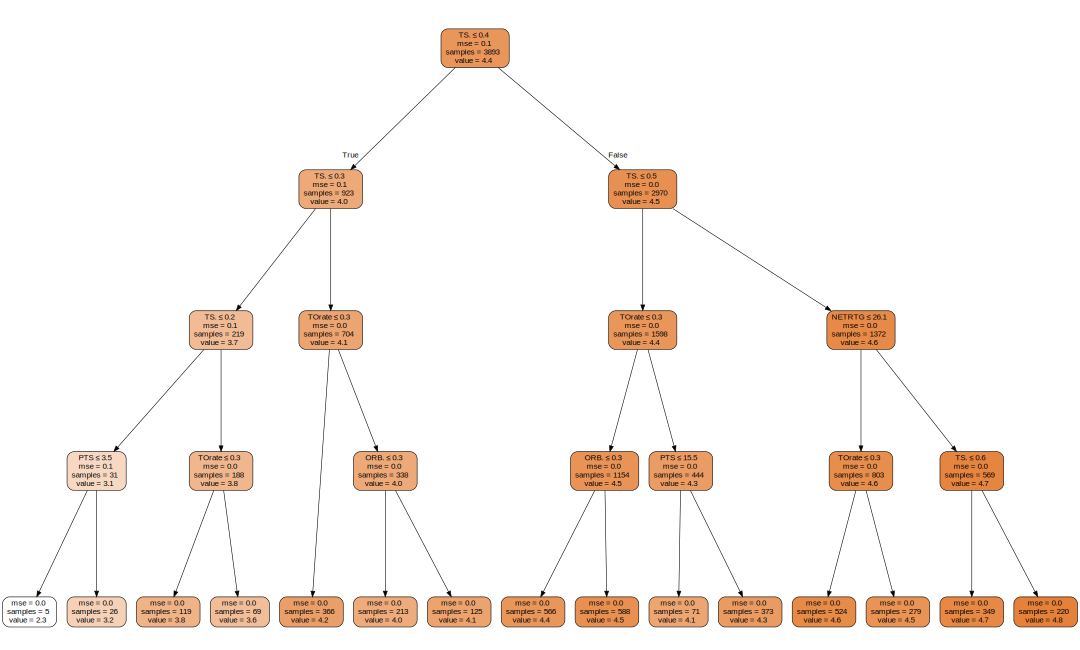

In [287]:
draw_tree(m, xs, size=15, leaves_parallel=True, precision=1)

Showing the same information using Terence Parr's [dtreeviz](https://github.com/parrt/dtreeviz) library:

/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in true_divide
  ret = ret.dtype.type(ret / rcount)


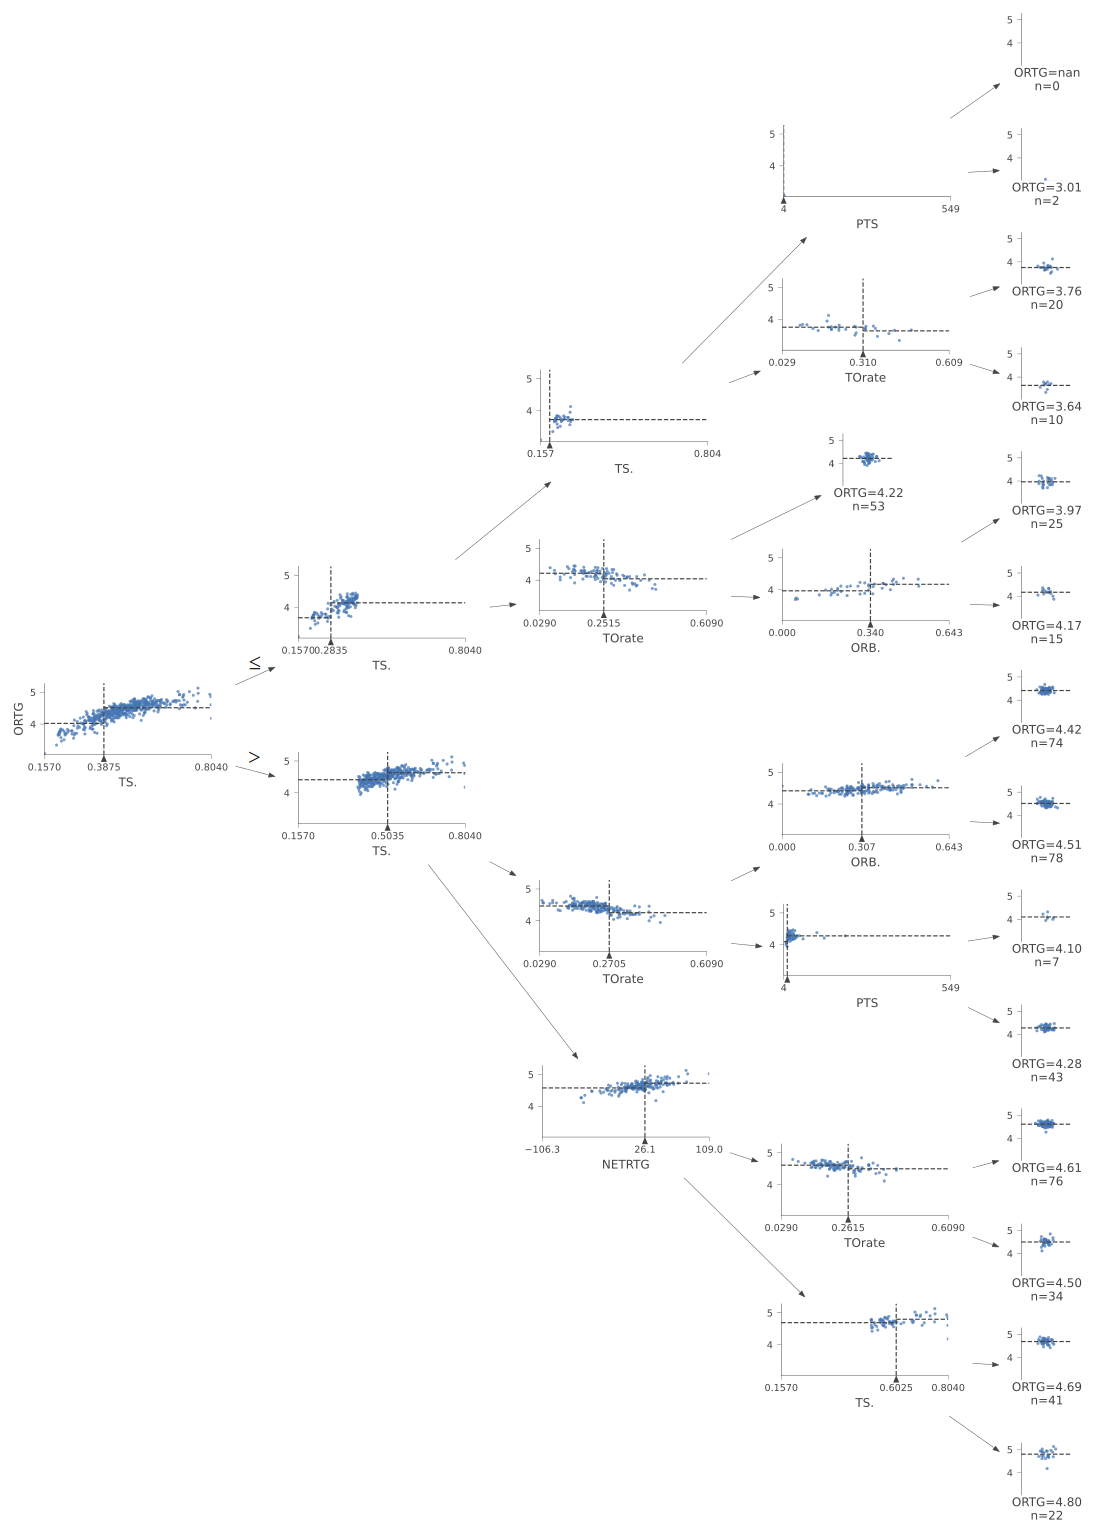

In [288]:
samp_idx = np.random.permutation(len(y))[:500]
dtreeviz(m, xs.iloc[samp_idx], y.iloc[samp_idx], xs.columns, dep_var,
        fontname='DejaVu Sans', scale=1.6, label_fontsize=10,
        orientation='LR')

In [289]:
m = DecisionTreeRegressor()
m.fit(xs, y);

In [290]:
#calculate our model's root mean squared error (m_rmse)
def r_mse(pred,y): return round(math.sqrt(((pred-y)**2).mean()), 6)
def m_rmse(m, xs, y): return r_mse(m.predict(xs), y)

In [291]:
#our training set rmse is near 0
m_rmse(m, xs, y)

3e-05

In [292]:
# but our validation set's rmse is a bit higher
m_rmse(m, valid_xs, valid_y)

0.087231

In [293]:
# there are lots of leaf nodes
m.get_n_leaves(), len(xs)

(3449, 3893)

In [294]:
# we limit the leaf nodes to those which have at least 25 samples in them and get a more reasonable rmse for training & validation sets
m = DecisionTreeRegressor(min_samples_leaf=25)
m.fit(to.train.xs, to.train.y)
m_rmse(m, xs, y), m_rmse(m, valid_xs, valid_y)

(0.079987, 0.092966)

In [295]:
#the number of leaves is much more reasonable now
m.get_n_leaves()

119

## Analyzing the Data with Random Forests

Next we try using a random forest to analyze the data.

In [ ]:
#hide
#!pip3 install -f https://sklearn-nightly.scdn8.secure.raxcdn.com scikit-learn

### Creating a Random Forest Using sklearn

In [297]:
#this function creates a random forest regressor and fits it to independent variables (xs) and a dependent variable (y)
def rf(xs, y, n_estimators=40, max_samples=1000,
       max_features=0.5, min_samples_leaf=5, **kwargs):
    return RandomForestRegressor(n_jobs=-1, n_estimators=n_estimators,
        max_samples=max_samples, max_features=max_features,
        min_samples_leaf=min_samples_leaf, oob_score=True).fit(xs, y)

In [298]:
m = rf(xs, y);

In [299]:
#this gets even better results than the Decision Tree!
m_rmse(m, xs, y), m_rmse(m, valid_xs, valid_y)

(0.065957, 0.076898)

In [300]:
preds = np.stack([t.predict(valid_xs) for t in m.estimators_])

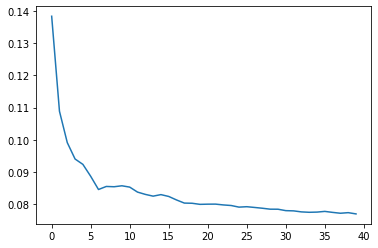

In [301]:
#our accuracy improves the more and more trees we add, though the improvement slows down after a while
plt.plot([r_mse(preds[:i+1].mean(0), valid_y) for i in range(40)]);

## Model Interpretation

What insight can we generate from these models?

### Plotting Feature Importance

In [302]:
def rf_feat_importance(m, df):
    return pd.DataFrame({'cols':df.columns, 'imp':m.feature_importances_}
                       ).sort_values('imp', ascending=False)

In [303]:
#here are our top 10 features in terms of importance
fi = rf_feat_importance(m, xs)
fi[:10]

,cols,imp
50,TS.,0.406718
48,eFG.,0.194518
12,NETRTG,0.092890
42,FG.,0.076843
13,PTS,0.061751
66,TOrate,0.061202
70,ORB.,0.024174
17,FGM,0.015895
37,TO,0.009301
11,DRTG,0.006674


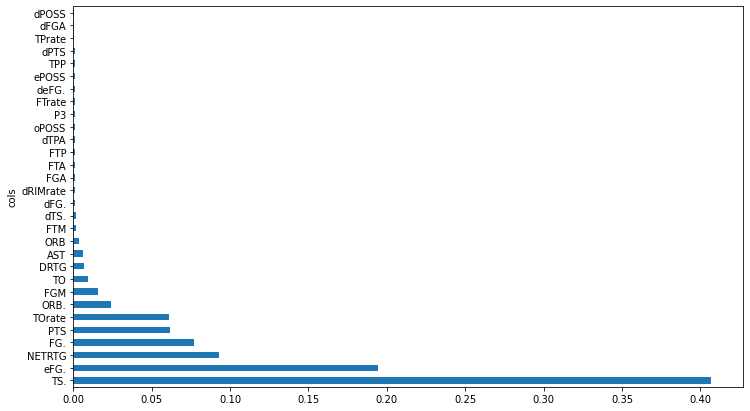

In [304]:
#here's a plot of our most important features
def plot_fi(fi):
    return fi.plot('cols', 'imp', 'barh', figsize=(12,7), legend=False)

plot_fi(fi[:30]);

### Removing Low-Importance Variables

In [305]:
#we remove the features that aren't very important
to_keep = fi[fi.imp>0.005].cols
len(to_keep)

11

In [306]:
xs_imp = xs[to_keep]
valid_xs_imp = valid_xs[to_keep]

In [307]:
m = rf(xs_imp, y)

In [308]:
#this still gives us a good prediction
m_rmse(m, xs_imp, y), m_rmse(m, valid_xs_imp, valid_y)

(0.067258, 0.074519)

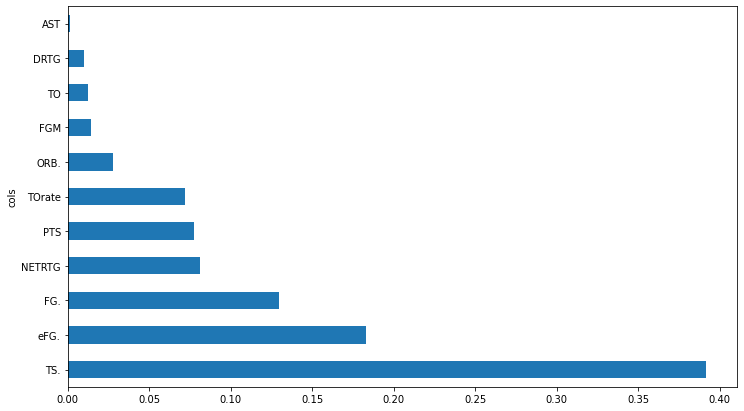

In [310]:
#here's the new plot of feature importance after removing the not important features
plot_fi(rf_feat_importance(m, xs_imp));

### Investigate Feature Redundancy

Are some of our features redundant?

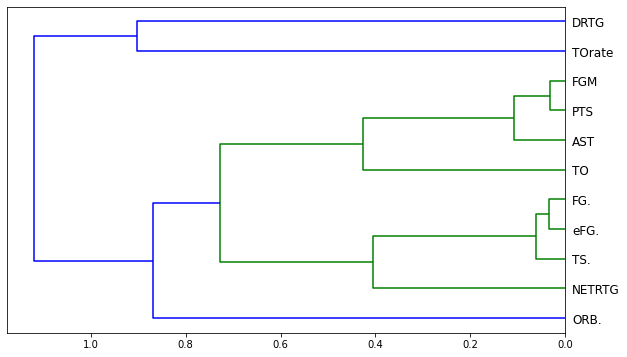

In [311]:
cluster_columns(xs_imp)

In [319]:
def get_oob(df):
    m = RandomForestRegressor(n_estimators=40, min_samples_leaf=15,
        max_samples=1000, max_features=0.5, n_jobs=-1, oob_score=True)
    m.fit(df, y)
    return m.oob_score_

In [320]:
get_oob(xs_imp)

0.909127154372597

In [321]:
#remove FG., FGM, and eFG., because they are similar to TS. and PTS
#this improves our OOB score
to_drop = ['FG.', 'FGM', 'eFG.']
get_oob(xs_imp.drop(to_drop, axis=1))

0.9155733390403249

In [322]:
xs = xs_imp.drop(to_drop, axis=1)
valid_xs = valid_xs_imp.drop(to_drop, axis=1)

In [323]:
save_pickle('xs.pkl', xs)
save_pickle('valid_xs.pkl', valid_xs)

In [324]:
xs = load_pickle('xs.pkl')
valid_xs = load_pickle('valid_xs.pkl')

In [325]:
#removing redundant features still gives us a good prediction
m = rf(xs, y)
m_rmse(m, xs, y), m_rmse(m, valid_xs, valid_y)

(0.061264, 0.069554)

### Partial Dependence

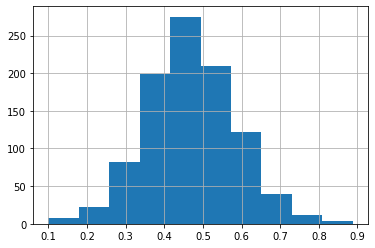

In [326]:
#look at TS. histogram
ax = valid_xs['TS.'].hist()

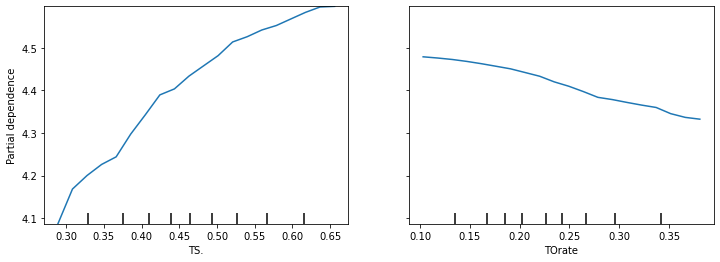

In [327]:
#Partial dependence tells us how much ORTG changes when a given variable changes, all else equal
#The below plots show how much ORTG changes when TS. and TOrate change, all else equal

from sklearn.inspection import plot_partial_dependence

fig,ax = plt.subplots(figsize=(12, 4))
plot_partial_dependence(m, valid_xs, ['TS.','TOrate'],
                        grid_resolution=20, ax=ax);

## Extrapolation and Neural Networks

Can we improve our predictions using a neural network?

In [328]:
df_nn = df
df_nn[dep_var] = np.log(df_nn[dep_var])

In [329]:
cont_nn,cat_nn = cont_cat_split(df_nn, max_card=1000, dep_var=dep_var)

In [330]:
df_nn.head()

,P1,P2,P3,P4,P5,Team,Mins,oMins,dMins,oPOSS,dPOSS,ORTG,DRTG,NETRTG,PTS,dPTS,FGA,dFGA,FGM,dFGM,TPA,dTPA,TPM,dTPM,FTA,dFTA,FTM,dFTM,RIMA,dRIMA,RIMM,dRIMM,ORB,dORB,DRB,dDRB,BLK,dBLK,TO,dTO,AST,dAST,ePOSS,FG.,dFG.,TPP,dTPP,FTP,dFTP,eFG.,deFG.,TS.,dTS.,RIM.,dRIM.,MID.,dMID.,TPrate,dTPrate,RIMrate,dRIMrate,MIDrate,dMIDrate,FTrate,dFTrate,ASTrate,dASTrate,TOrate,dTOrate,BLKrate,oBLKrate,ORB.,DRB.,TimePerPoss,dTimePerPoss
37,.BETONEY,.COOK,.JONES,.MALUYO,.SIKORA,Evergreen St.,22.650,8.333,14.317,36,38,1.453893,84.211,-11.988,26,32,26,30,10,11,13,16,4,5,4,7,2,5,11,7,4,3,3,8,9,16,0,1,9,13,8,9,36.0,0.385,0.367,0.308,0.312,0.500,0.714,0.462,0.450,0.466,0.480,0.364,0.429,1.000,0.429,0.500,0.533,0.423,0.233,0.077,0.233,0.154,0.233,0.800,0.818,0.250,0.342,0.0,0.038,0.158,0.529,13.889,22.605
66,.DIMITRAKOPOULOU,ANNALIESE.SCHREDER,EMMA.GALLAGHER,OLIVIA.PARISI,STELLA.DAVIS,William Smith,27.383,5.750,21.633,23,25,1.472483,88.000,-9.739,18,22,25,20,6,7,9,4,4,1,2,8,2,7,13,12,2,4,9,4,9,9,0,0,5,3,2,2,22.5,0.240,0.350,0.444,0.250,1.000,0.875,0.320,0.375,0.347,0.462,0.154,0.333,0.000,0.500,0.360,0.200,0.520,0.600,0.120,0.200,0.080,0.400,0.333,0.286,0.217,0.120,0.0,0.000,0.500,0.692,15.000,51.920
73,.DIMITRAKOPOULOU,ANNALIESE.SCHREDER,LAUREN.DEVANEY,OLIVIA.PARISI,STELLA.DAVIS,William Smith,27.450,7.083,20.367,23,25,1.517480,76.000,19.652,22,19,23,20,5,7,10,11,2,4,15,2,10,1,8,7,2,2,12,1,12,9,0,2,5,5,5,4,24.0,0.217,0.350,0.200,0.364,0.667,0.500,0.261,0.450,0.365,0.453,0.250,0.286,0.200,0.500,0.435,0.550,0.348,0.350,0.217,0.100,0.652,0.100,1.000,0.571,0.217,0.200,0.0,0.087,0.571,0.923,18.478,48.880
114,.GUWBB,CLARISSA.DUEBEL,EMILY.REINNECK,MADELYN.STEPHEN,MEGAN.BARRETT,Greenville,34.650,25.117,9.533,46,46,1.507227,80.435,10.870,42,37,32,36,15,14,9,13,3,2,16,9,9,7,18,13,9,10,5,5,19,15,0,2,6,7,9,6,41.5,0.469,0.389,0.333,0.154,0.562,0.778,0.516,0.417,0.530,0.459,0.500,0.769,0.600,0.200,0.281,0.361,0.562,0.361,0.156,0.278,0.500,0.250,0.600,0.429,0.130,0.152,0.0,0.062,0.250,0.792,32.761,12.435
117,.HFC,BRIANNA.HOLCOMB,MACKENZIE.KOLESARI,MIKAYLA.REIMER,SHARELL.BALL,Holy Fam. Col. (WI),19.500,10.933,8.567,37,35,1.447471,102.857,-32.587,26,36,30,33,9,15,19,10,4,2,7,5,4,4,0,0,0,0,2,7,11,21,0,0,5,6,5,9,35.0,0.300,0.455,0.211,0.200,0.571,0.800,0.367,0.485,0.390,0.509,0.000,0.000,0.455,0.565,0.633,0.303,0.000,0.000,0.367,0.697,0.233,0.152,0.556,0.600,0.135,0.171,0.0,0.000,0.087,0.611,17.730,14.686


In [332]:
df_nn[cat_nn].nunique()

P1      1288
P2      1586
P3      1696
P4      1621
P5      1287
        ... 
dBLK      33
TO       108
dTO      118
AST       99
dAST      90
Length: 36, dtype: int64

In [334]:
#we remove columns we don't care about to simplify the nn
cat_nn.remove('P1')
cat_nn.remove('P2')
cat_nn.remove('P3')
cat_nn.remove('P4')
cat_nn.remove('P5')
cat_nn.remove('Team')

In [335]:
#we use fastai to normalize the data
procs_nn = [Categorify, FillMissing, Normalize]
to_nn = TabularPandas(df_nn, procs_nn, cat_nn, cont_nn,
                      splits=splits, y_names=dep_var)

In [336]:
dls = to_nn.dataloaders(1024)

In [337]:
#we look at the min and max ORTG in the training set
y = to_nn.train.y
y.min(),y.max()

(0.7005710601806641, 1.6402279138565063)

In [338]:
#we create our tabular nearning model
learn = tabular_learner(dls, y_range=(.65,1.7), layers=[500,250],
                        n_out=1, loss_func=F.mse_loss)

SuggestedLRs(valley=tensor(0.0021))

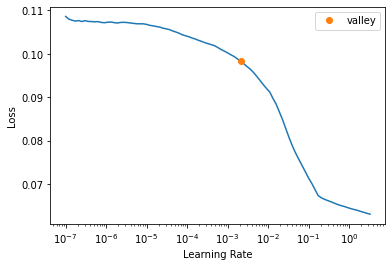

In [339]:
#we find a good learning rate
learn.lr_find()

In [343]:
#train a bunch of epochs
learn.fit_one_cycle(20, 0.0021)

epoch,train_loss,valid_loss,time
0,0.001234,0.001878,00:00
1,0.001147,0.002336,00:00
2,0.001278,0.001875,00:00
3,0.001241,0.001721,00:00
4,0.001183,0.002145,00:00
5,0.001102,0.001863,00:00
6,0.001078,0.001740,00:00
7,0.001134,0.002154,00:00
8,0.001176,0.002288,00:00
9,0.001153,0.001643,00:00


In [344]:
#our neural net is even better than our random forest!
preds,targs = learn.get_preds()
r_mse(preds,targs)

0.032522

In [345]:
learn.save('nn')

Path('models/nn.pth')

##Conclusion

We began with a dataset that looked at >5.8k games from the 2019-2020 DIII NCAA WBB season aggregated by lineup. Our goal was to investigate what variables would predict ORTG.

As we may have anticipated, TS. was by far the best predictor of ORTG, followed by eFG. and FG.. 

After that, NETRTG and PTS were the best predictors, which tells us that the best lineups in general, i.e. those with a good net rating and those which were on the floor long enough to score a lot of PTS, tended to have better ORTGs.

Finally TOrate was also an important factor, followed by ORB.. This goes to show that taking care of the ball tends to be even more important than crashing the glass in contributing to ORTG.

After more and more refinement, our models became extremely accurate in predicting ORTG, with our neural network ultimately having the best predictive power. How this might be used in helping coaches determine which lineups to play or which tactics to emphasize is still to-be-determined. There is likely more insight into ORTG that could be unlocked using machine learning. 